In [ ]:
#%load_ext autoreload
#%reload_ext autoreload
#%autoreload 2      
from IPython.display import Image, display, clear_output

import itertools
from operator import itemgetter
# opencv, numpy
import cv2
import numpy as np
np.set_printoptions(precision=2)

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
matplotlib.rcParams['figure.figsize'] = (19, 10)

# bundle adjustment
import pysba as ba

# project files
import utils as utils
from common_misc import homogeneous2euclidean, euclidean2homogeneous, projective2img, img2projective, plot_camera
import maths as mth
import image_matches as mt
import fundamental as fd
import track as tk
import vps as vp
import reconstruction as rc

with_intrinsics = True

## Conventions on notation 
In the code provided we try to differentiate between variables holding homogeneous and euclidean coordinates. Any variable $x$ holding homogeneous coordinates will be denoted as $x_h$ and its code correspondant as `x_h`. Accordingly the euclidean coordinates will be denoted as $x_e$, `x_e`.

# Structure from Motion 
In this final laboratory, the main goal is to design a complete Structure from Motion
(SfM) pipeline in order to achieve a 3D reconstruction of the given uncalibrated images.
The real data that we are using are 5 facade images, the ones that have been used in
the previous labs. You can use [more images](https://docs.opencv.org/3.4/d7/dd5/group__datasets__msm.html) or another sequence of images if you like: 

* All datasets, with ground-truth, and cameras: [home](https://icwww.epfl.ch/multiview/denseMVS.html)
* Castle dataset: [castle](https://icwww.epfl.ch/multiview/castle_dense_large.html)


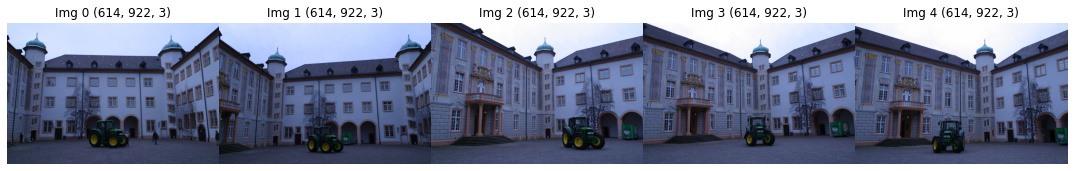

In [ ]:
n_imgs = 5
rgb_imgs, gray_imgs = utils.load_n_images(n_imgs)
fig = utils.plot_images(rgb_imgs)

The processing of the images is computationally demanding, so perhaps at start its best to load only a couple of the images

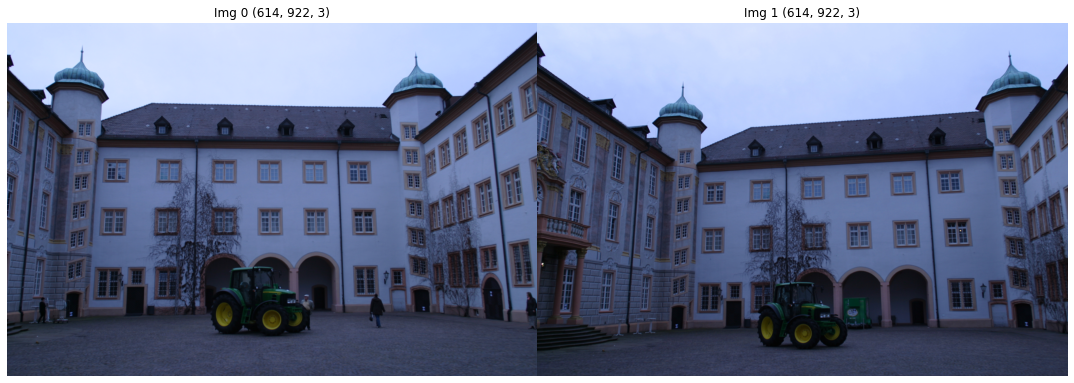

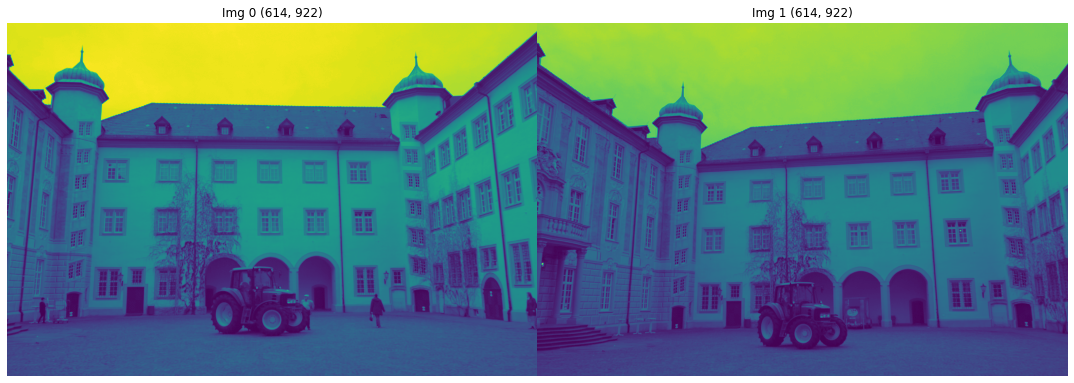

In [ ]:
n_imgs = 2
rgb_imgs, gray_imgs = utils.load_n_images(n_imgs)

fig = utils.plot_images(rgb_imgs)
fig2 = utils.plot_images(gray_imgs)

The function `process_images` takes the list of loaded images and generates all the required features and data for the assignment. You are encouraged to understand how the pipeline is working and to modify it. See its documentation for details on the return types.

If you perform changes the feature extraction and matching pipeline, make sure to verify the quality of the results. That is, if your Fundamental Matrix estimates are bad, you can probably spot them by eye before proceeding.

  Features detected in image  0
    Found 2955 features 
  Features detected in image  0
    Found 3010 features 
  Vanishing points found


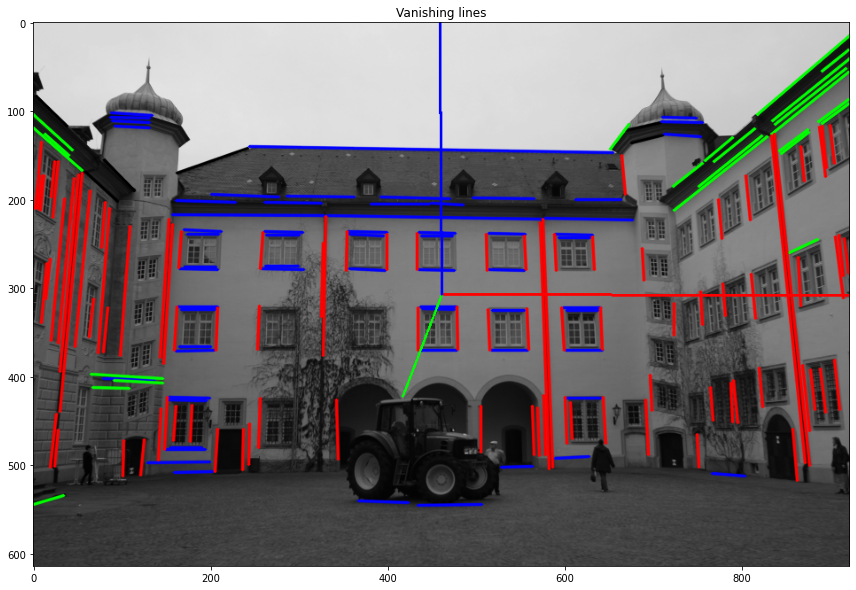

  Vanishing points found


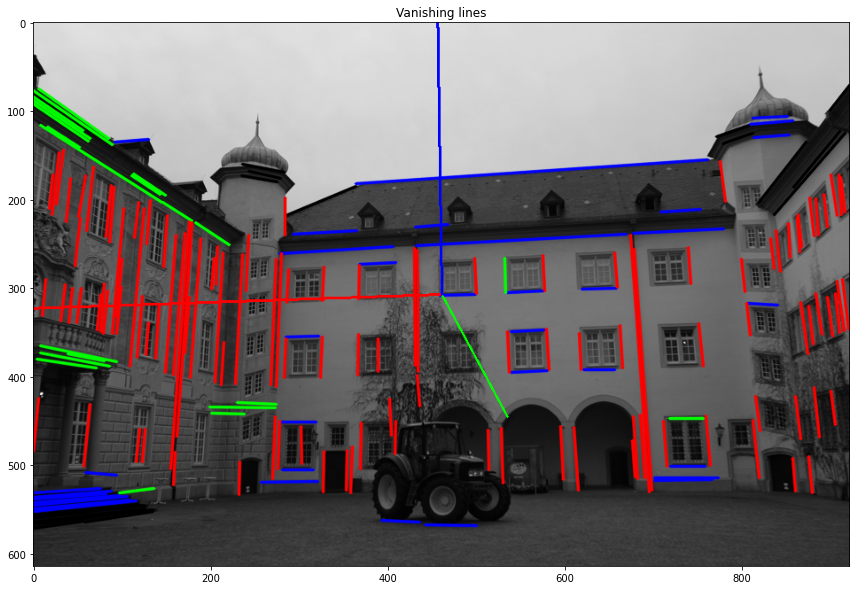

	 Matching images 0 and 1  for obtaining tracks
Robust estimation of Fundamental Matrix. Iter: 25 Num-Inliers: 871
Before cleaning: (3, 1058) (3, 1058)
After cleaning: (3, 871) (3, 871)
  Matches corrected with Optimal Triangulation Method
  Tracks added after matching 0 and 1
    Size of tracks: 802
    Size of hash table of views: 1612


In [ ]:
import utils

orb_features = [None] * n_imgs      # list of features per image
tracks = []                         # list of tracking views 
hs_vs = {}                          # dictionary as hash table of views-tracks
vanish_pts = [None] * n_imgs        # list of vanishing points per image 
cams_pr = [None] * n_imgs           # list of projective cameras per image 
cams_aff = [None] * n_imgs          # list of affine cameras per image 
cams_euc = [None] * n_imgs          # list of euclidean cameras per image 
Xprj = {}              # Dict of projective 3d points per image pairs 
Xaff = {}              # Dict of affine 3d points per image pairs
Xeuc = {}              # Dict of euclidean 3d points per image pairs

img_pairs_features, orb_features, vanish_pts, tracks, hs_vs = utils.process_images_sift(rgb_imgs, gray_imgs)
# clear_output()

Showing data from Cam0 and Cam1
- Fundamental Matrix F:
 [[-2.92e-06 -3.46e-04  1.73e-01]
 [ 7.30e-05 -2.47e-05  9.67e-01]
 [-4.48e-02 -7.86e-01 -1.04e+02]]


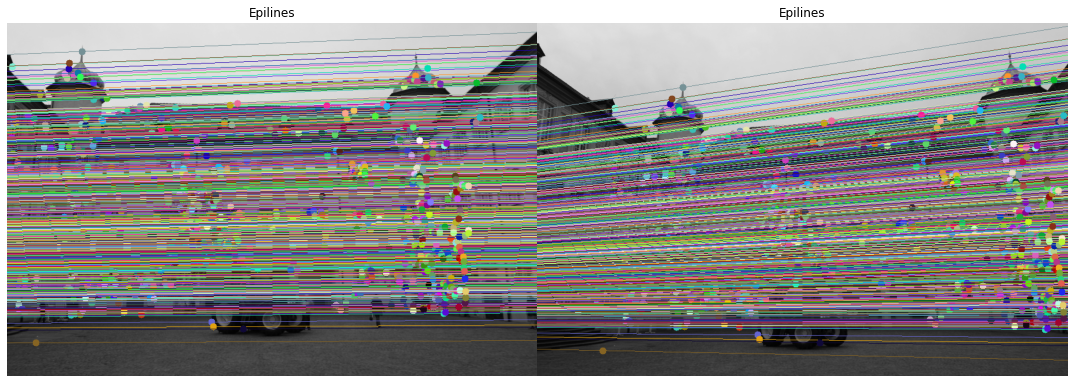

In [ ]:
for (img1_id, img2_id) in img_pairs_features.keys():
    print(f"Showing data from Cam{img1_id} and Cam{img2_id}")
    img12_feat = img_pairs_features[(img1_id, img2_id)]
    F = img12_feat.F                          # Estimated fundamental matrix F
    matches = img12_feat.matches              # All matches between images 
    inliers_idx = img12_feat.inliers_idx      # All F inlier indices of matches 
    x1_e = img12_feat.x1_e
    x2_e = img12_feat.x2_e
    xr1_e = img12_feat.xr1_e
    xr2_e = img12_feat.xr2_e
    x1_h = img12_feat.x1_h
    x2_h = img12_feat.x2_h
    # Choose some inliers for clearer visualization 
    selected_inliers = np.random.choice(inliers_idx, 50)

    print(f"- Fundamental Matrix F:\n", F)
    """img_ij = cv2.drawMatches(gray_imgs[img1_id], orb_features[img1_id][0],
                             gray_imgs[img2_id], orb_features[img2_id][0],
                             itemgetter(*selected_inliers)(matches),
                             None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)"""

    #plt.title("Matches")
    #plt.imshow(img_ij)
    
    selected_display = np.random.choice([i for i in range(x1_h.shape[1])], 50)
    imgs = utils.display_epilines(gray_imgs[img1_id], gray_imgs[img2_id], 
                                  xr1_e.T, 
                                  xr2_e.T, F) #[selected_display,:], F)

    fig = utils.plot_images(imgs, titles=["Epilines"]*2)

In [ ]:
from shapely.geometry import Point, LineString

img12_feat = img_pairs_features[(0, 1)]
F = img12_feat.F                          # Estimated fundamental matrix F
matches = img12_feat.matches              # All matches between images 
inliers_idx = img12_feat.inliers_idx      # All F inlier indices of matches 
x1_e = img12_feat.x1_e
x2_e = img12_feat.x2_e
xr1_e = img12_feat.xr1_e
xr2_e = img12_feat.xr2_e
x1_h = img12_feat.x1_h
x2_h = img12_feat.x2_h

idxs_ps2 = []
cleared_1 = 0

total_selected_lines = []
total_selected_points = []
for i in range(3):
    lines_vp = vanish_pts[1][1][i]
    points_in_lines = []
    lines_selected = []
    
    for line in lines_vp:
        segment = LineString([(line[0], line[1]), (line[2], line[3])])
        selected_points = []
        distances = []
        for points in xr2_e.T:
            p = Point(points[0], points[1])
            dist = segment.distance(p)
            distances.append(dist)
            # if dist < 3:
            #selected_points.append(dist)
            
            #if len(selected_points) == 2:
            #    break
            
        distances = np.array(distances)
        #idx = np.argpartition(-distances, -2)[-2:]
        #indices = idx[np.argsort((-distances)[idx])]
        idx = np.argmin(distances)
        p1 = xr2_e.T[idx]
        
        
        if distances[idx] < 12:
            for idx_p2 in range(len(xr2_e.T)):
                if idx != idx_p2:
                    p2 = xr2_e.T[idx_p2]
                    segment2 = LineString([(p1[0], p1[1]), (p2[0], p2[1])])
                    slope1, intersect1 = np.polyfit(segment.coords.xy[0], segment.coords.xy[1], 1)
                    slope2, intersect2 = np.polyfit(segment2.coords.xy[0], segment2.coords.xy[1], 1)

                    if abs(slope1 - slope2) < np.pi/12 and distances[idx_p2] < 12 and np.linalg.norm(p1-p2, 2) > 3:
                        selected_points.append(xr2_e.T[idx])
                        selected_points.append(xr2_e.T[idx_p2])
                        idxs_ps2.append([idx, idx_p2])
                        break

                        
            if len(selected_points) == 2:
                lines_selected.append(line)
                points_in_lines.append(selected_points)

        
        if len(selected_points) == 2:
            if len(selected_points) > 0:
                if np.linalg.norm(line-lines_selected[-1]) > 1e-2:
                    lines_selected.append(line)
                    points_in_lines.append(selected_points)
            else:
                lines_selected.append(line)
                points_in_lines.append(selected_points)
        
        if len(lines_selected) == 2:
            total_selected_lines.append(lines_selected)
            total_selected_points.append(points_in_lines)
            break


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
total_selected_lines

[[array([851.97, 106.48, 812.93, 108.98], dtype=float32),
  array([809.94, 115.28, 857.95, 111.38], dtype=float32)],
 [array([221.84, 251.25, 183.73, 226.42], dtype=float32),
  array([230.98, 429.33, 274.03, 431.45], dtype=float32)],
 [array([155.74, 504.98, 176.04, 225.86], dtype=float32),
  array([149.7 , 395.98, 161.7 , 240.05], dtype=float32)]]

[]

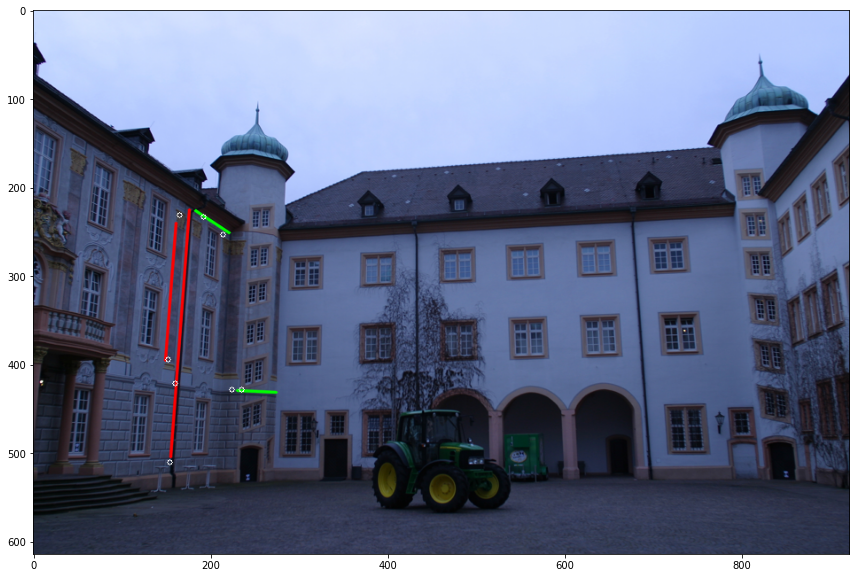

In [ ]:
copy_color = rgb_imgs[1].copy()
colours = 255 * np.eye(3)
# BGR format
# First row is red, second green, third blue
colours = colours[:, ::-1].astype(np.int).tolist()

for i in [1,2]:
    points = total_selected_points[i]
    lines = total_selected_lines[i]
    for (x1,y1,x2,y2) in lines:
        cv2.line(copy_color, (int(x1), int(y1)), (int(x2), int(y2)), colours[i], 2, cv2.LINE_AA)
    for point in points:
        for j in range(2):
            cv2.circle(copy_color, (int(point[j][0]), int(point[j][1])), 3, (255,255,255))

plt.imshow(copy_color)
plt.plot()

In [ ]:
from shapely.geometry import Point, LineString

img12_feat = img_pairs_features[(0, 1)]
F = img12_feat.F                          # Estimated fundamental matrix F
matches = img12_feat.matches              # All matches between images 
inliers_idx = img12_feat.inliers_idx      # All F inlier indices of matches 
x1_e = img12_feat.x1_e
x2_e = img12_feat.x2_e
xr1_e = img12_feat.xr1_e
xr2_e = img12_feat.xr2_e
x1_h = img12_feat.x1_h
x2_h = img12_feat.x2_h

idxs_ps1 = []
cleared_1 = 0

total_selected_lines = []
total_selected_points = []
for i in range(3):
    lines_vp = vanish_pts[0][1][i]
    points_in_lines = []
    lines_selected = []
    
    for line in lines_vp:
        segment = LineString([(line[0], line[1]), (line[2], line[3])])
        selected_points = []
        distances = []
        for points in xr1_e.T:
            p = Point(points[0], points[1])
            dist = segment.distance(p)
            distances.append(dist)
            # if dist < 3:
            #selected_points.append(dist)
            
            #if len(selected_points) == 2:
            #    break
            
        distances = np.array(distances)
        #idx = np.argpartition(-distances, -2)[-2:]
        #indices = idx[np.argsort((-distances)[idx])]
        idx = np.argmin(distances)
        p1 = xr1_e.T[idx]
        
        if len(selected_points) > 0:
            if np.linalg.norm(selected_points[-1]-p1) < 1e-2 or np.linalg.norm(selected_points[-2]-p1) < 1e-2:
                continue
        
        if distances[idx] < 4:
            for idx_p2 in range(len(xr1_e.T)):
                if idx != idx_p2:
                    p2 = xr1_e.T[idx_p2]
                    segment2 = LineString([(p1[0], p1[1]), (p2[0], p2[1])])
                    slope1, intersect1 = np.polyfit(segment.coords.xy[0], segment.coords.xy[1], 1)
                    slope2, intersect2 = np.polyfit(segment2.coords.xy[0], segment2.coords.xy[1], 1)

                    if abs(slope1 - slope2) < np.pi/12 and distances[idx_p2] < 4 and np.linalg.norm(p1-p2, 2) > 150:
                        selected_points.append(xr1_e.T[idx])
                        selected_points.append(xr1_e.T[idx_p2])
                        idxs_ps1.append([idx, idx_p2])
                        break

                            
        if i == 2:
            if len(selected_points) == 2:
                if cleared_1 < 4:
                    cleared_1 += 1
                    del selected_points[-1]
                    #del lines_selected[-1] #= []
                    distances = []
                    # lines_selected = []
                    del idxs_ps[-1]
                else:
                    lines_selected.append(line)
                    points_in_lines.append(selected_points)

        
        if len(selected_points) == 2:
            if len(lines_selected) > 0:
                if np.linalg.norm(lines_selected[-1]-line) > 1e-2:
                    lines_selected.append(line)
                    points_in_lines.append(selected_points)
            else:
                lines_selected.append(line)
                points_in_lines.append(selected_points)
        
        if len(lines_selected) == 2:
            total_selected_lines.append(lines_selected)
            total_selected_points.append(points_in_lines)
            break


  exec(code_obj, self.user_global_ns, self.user_ns)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj

In [ ]:
total_selected_lines

[[array([244.03, 140.19, 654.98, 147.9 ], dtype=float32),
  array([573.01, 222.07, 332.  , 218.69], dtype=float32)]]

[]

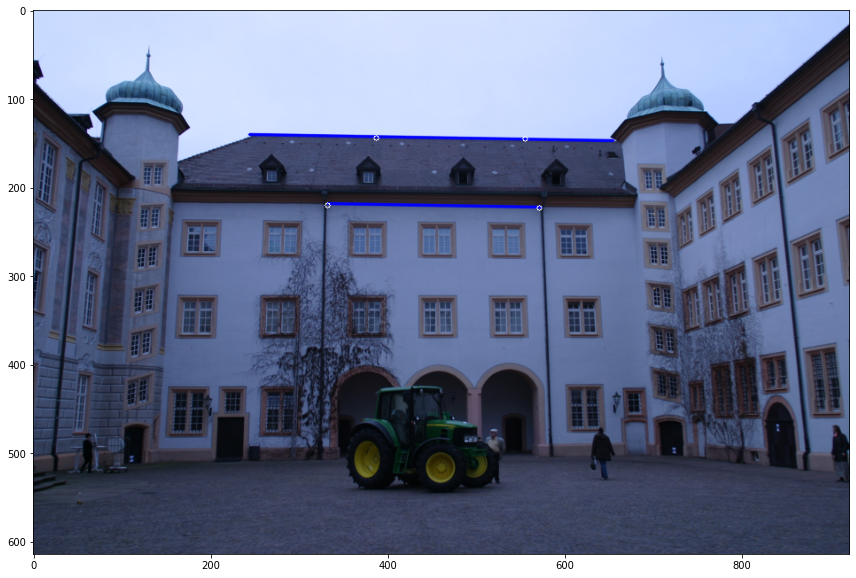

In [ ]:
copy_color = rgb_imgs[0].copy()
colours = 255 * np.eye(3)
# BGR format
# First row is red, second green, third blue
colours = colours[:, ::-1].astype(np.int).tolist()

for i in [0]:
    points = total_selected_points[i]
    lines = total_selected_lines[i]
    for (x1,y1,x2,y2) in lines:
        cv2.line(copy_color, (int(x1), int(y1)), (int(x2), int(y2)), colours[i], 2, cv2.LINE_AA)
    for point in points:
        for j in range(2):
            cv2.circle(copy_color, (int(point[j][0]), int(point[j][1])), 3, (255,255,255))

plt.imshow(copy_color)
plt.plot()

In [ ]:

idxs_ps = [idxs_ps1[0], idxs_ps1[1], idxs_ps2[2], idxs_ps2[3], idxs_ps2[4], idxs_ps2[5]]

In [ ]:
img12_feat = img_pairs_features[(img1_id, img2_id)]
F = img12_feat.F                          # Estimated fundamental matrix F
matches = img12_feat.matches              # All matches between images 
inliers_idx = img12_feat.inliers_idx      # All F inlier indices of matches 
xr1_e = img12_feat.xr1_e.T
xr2_e = img12_feat.xr2_e.T

img1_rgb = rgb_imgs[0].copy()
img2_rgb = rgb_imgs[1].copy()
colors = np.random.randint(0, 255, size=(len(idxs_ps), 3)).tolist()

for i, indices in enumerate(idxs_ps):
    cv2.circle(img1_rgb, (int(xr1_e[indices[0]][0]), int(xr1_e[indices[0]][1])), 3, colors[i], -1)
    cv2.circle(img1_rgb, (int(xr1_e[indices[1]][0]), int(xr1_e[indices[1]][1])), 3, colors[i], -1)

for i, indices in enumerate(idxs_ps):
    cv2.circle(img2_rgb, (int(xr2_e[indices[0]][0]), int(xr2_e[indices[0]][1])), 3, colors[i], -1)
    cv2.circle(img2_rgb, (int(xr2_e[indices[1]][0]), int(xr2_e[indices[1]][1])), 3, colors[i], -1)

[]

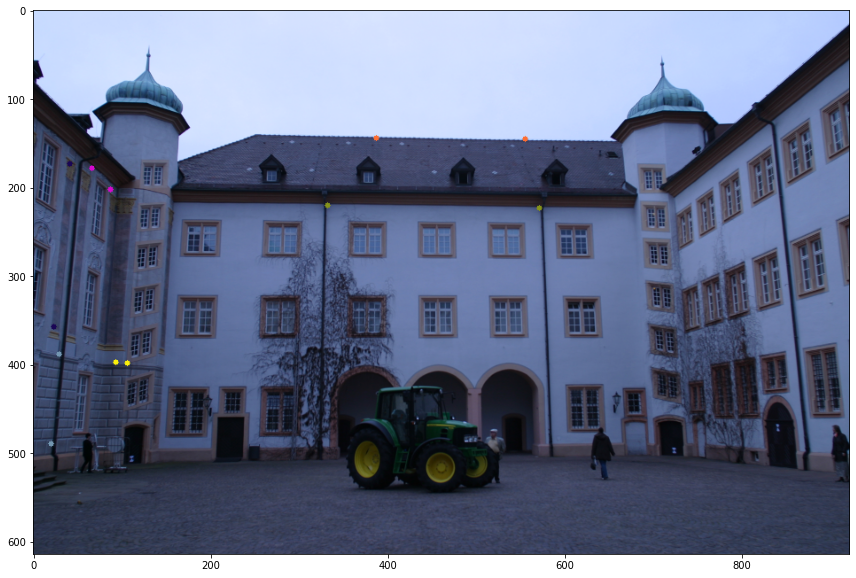

In [ ]:
plt.imshow(img1_rgb)
plt.plot()


[]

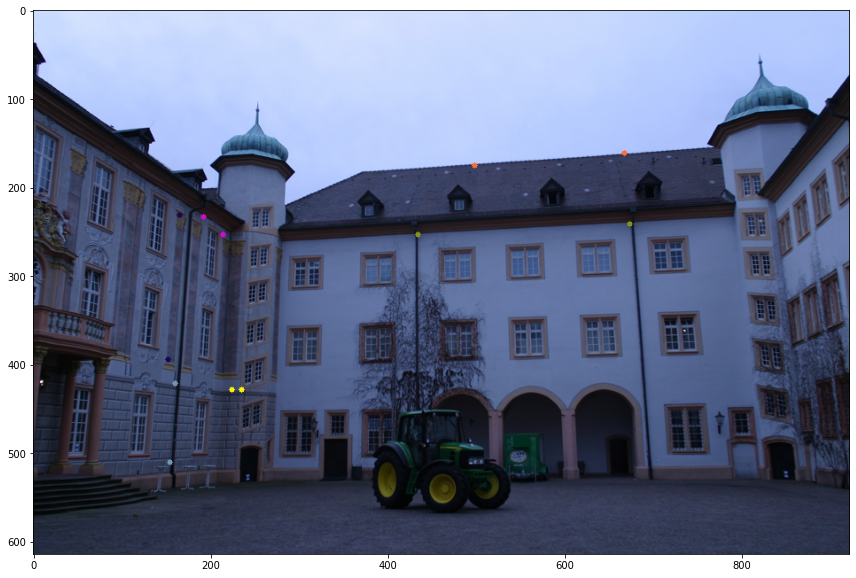

In [ ]:
plt.imshow(img2_rgb)
plt.plot()

# 1. Computation of Projective cameras (n=2)

Compute the estimated Projective Camera Matrices for each of the Cameras in the images.
See Result 9.15 of MVG

In [ ]:
import scipy

def decompose_P(P):
    M = P[:, :-1]
    K, R = scipy.linalg.rq(M)
    
    # ensure K has positive diagonal
    T = np.diag(np.sign(np.diag(K))) 
    K = np.dot(K, T)
    R = np.dot(T, R)
    t = np.linalg.solve(K, P[:,3])
    # ensure det(R) = 1
    if np.linalg.det(R) < 0:
        R = -R
        t = -t

    
    return K, R, t

In [ ]:
import plotly.graph_objects as go
from common_misc import optical_center, view_direction

def plot_camera_go(P, img_shape, fig, scale=2):
    h, w = img_shape

    o = optical_center(P)
    p1 = o + view_direction(P, np.array([0, 0, 1])) * scale;
    p2 = o + view_direction(P, np.array([w, 0, 1])) * scale;
    p3 = o + view_direction(P, np.array([w, h, 1])) * scale;
    p4 = o + view_direction(P, np.array([0, h, 1])) * scale;

    x = np.array([p1[0], p2[0], o[0], p3[0], p2[0], p3[0], p4[0], p1[0], o[0], p4[0], o[0], (p1[0]+p2[0])/2])
    y = np.array([p1[1], p2[1], o[1], p3[1], p2[1], p3[1], p4[1], p1[1], o[1], p4[1], o[1], (p1[1]+p2[1])/2])
    z = np.array([p1[2], p2[2], o[2], p3[2], p2[2], p3[2], p4[2], p1[2], o[2], p4[2], o[2], (p1[2]+p2[2])/2])

    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines'))

    return

def display_3d_points_with_cameras_go(v, cameras, c=None):
    fig = go.Figure()
    for camera in cameras:
        P, h, w, scale = camera
        plot_camera_go(P, [h, w], fig, scale=scale)
        
    if type(v) == np.ndarray:
        fig.add_trace(go.Scatter3d(x=v[:, 0], y=v[:, 1], z=v[:, 2], mode='markers', marker = dict(
                                        size = 2,
                                        opacity = 0.8
                                    )))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()


In [ ]:
cams_pr = [None]*n_imgs

def estimate_proj_camera(*args):
    # Result 9.15 of MVG (v = 0, lambda = 1). It assumes P1 = [I|0]
    F, lambda_Kt, v = args
    # First, we need to compute epipole from second view: Ft * e' = 0
    e_prime = mth.nullspace(F.transpose())
    e_prime = e_prime/e_prime.reshape(-1)[-1]
    e_prime_skew = mth.skew(e_prime.flatten()) 

    M = np.dot(e_prime_skew, F)
    print(M)
    S = e_prime.reshape(3, 1) @ v.reshape(1, 3) # add e_prime @ v.T so that M is not of rank 2 -> affine camera == origin at infinity -> hard to visualize
    print(S)
    M = M + S
    P = np.hstack([M, e_prime.reshape(3, 1)*lambda_Kt])
    # Correct sign so that both cameras point towards the same direction and 3D points are in front of the camera
    P /= P[2,2] 
    
    # print(np.linalg.matrix_rank(decompose_P(P)[1] - e_prime_skew@F))
    
    return P

def plot_cameras_and_points(X, P1, P2, rgb_img, x1, w=1, h=1, s=1):
    """
    You are encouraged to debug your program graphically
    """
    plt.figure()
    # Render the 3D point cloud
    x_img = np.transpose(x1[:2]).astype(int)
    rgb_txt = (rgb_img[x_img[:,1], x_img[:,0]])/255
    utils.draw_points(X.T, color=rgb_txt, ax=ax)
    utils.plot_camera(P1,w,h,s, ax=ax)
    utils.plot_camera(P2,w,h,s, ax=ax)
    
    
# Asume the Camera 0 of image 0 has a cannonical matrix P 
P0 = np.float32(np.c_[np.eye(3), np.zeros(3)])
cams_pr[0] = P0

for cam_id in range(1, len(rgb_imgs)):
    img12_feat = img_pairs_features[(img1_id, img2_id)]
    cams_pr[cam_id] = estimate_proj_camera(img12_feat.F, -3000, (5)*np.array([1, 1, 1])) #v =[10,10,10]

[[-2.33e+01 -4.10e+02 -5.40e+04]
 [-1.03e+02 -1.82e+03 -2.39e+05]
 [-1.67e-01  2.37e-01 -2.32e+03]]
[[-1.16e+04 -1.16e+04 -1.16e+04]
 [ 2.61e+03  2.61e+03  2.61e+03]
 [ 5.00e+00  5.00e+00  5.00e+00]]


### 1.2 Estimate the reprojection error 

In [ ]:
projective_error = [None] * len(cams_pr)

def euclid(x):
    return x[:, :-1] / x[:, [-1]]

def compute_reproj_error(X, P1, P2, xr1, xr2):
    # project 3D points using P
    xp1 = P1@X
    xp2 = P2@X
    xp1 = euclid(xp1.T).T
    xp2 = euclid(xp2.T).T

    # compute reprojection error
    error = np.sum(np.sum((xr1-xp1)**2)+np.sum((xr2-xp2)**2))

    return error

cameras_show = [[cams_pr[i], rgb_imgs[i].shape[0], rgb_imgs[i].shape[1], 1] for i in range(len(cams_pr))]
for cam_id in range(1, len(cams_pr)):
    img12_feat = img_pairs_features[(0, cam_id)]
    x1_e, x2_e = img12_feat.x1_e, img12_feat.x2_e
    xr1_e, xr2_e = img12_feat.xr1_e, img12_feat.xr2_e
    
    # Projective triangulation for 3D structure.
    Xp = rc.estimate_3d_points_2(cams_pr[cam_id-1], cams_pr[cam_id], xr1_e, xr2_e)
    Xprj[(0, cam_id)] = Xp
    # Add estimated 3d projective points to tracks
    tk.add_pts_tracks(Xp, x1_e.T, x2_e.T, cam_id-1, cam_id, tracks, hs_vs)
        
    # Compute reprojection error.
    error = compute_reproj_error(Xp, cams_pr[cam_id-1], cams_pr[cam_id], xr1_e, xr2_e)
    print("Reprojection error is:", error)
    projective_error[cam_id] = error
    points_show_3D_prj = Xp.T[:,:3]
    points_show_3D_prj = points_show_3D_prj[np.abs(points_show_3D_prj[:,0]) < 50000]
    points_show_3D_prj = points_show_3D_prj[np.abs(points_show_3D_prj[:,1]) < 50000]
    
    # Display points on each image 
    display_3d_points_with_cameras_go(points_show_3D_prj, cameras_show)

Reprojection error is: 6.379443841452858e-08


## 1.3 Affine Rectification
Perform an affine rectification, using an estimated Homography $H_{a\leftarrow p}$. Then, transform the projected 3D points and Projective Camera Matrices to Affine. 

Compute the reprojection error of the affine projected points, and compare with previous error.

# Approach 1

In [ ]:
def td_e_point_to_td_h(points):
    return np.hstack([points, np.ones((points.shape[0], 1))])

def td_h_point_to_td_e(points):
    return points[:, :3] / points[:,3,np.newaxis]


In [ ]:
def get_point_intersect_3d(set_of_points):
    """
    Set of points of the shape (4, n) where n is 4 (we need 4 points) and 4 bc homog coords P3
    """
    # Make sure they intersect
    U,D,Vt = np.linalg.svd(set_of_points.T)
    D = np.diag(D)
    D[-1,-1] = 0
    points_p1_3D_int = U@D@Vt
    points_p1_3D_int = td_h_point_to_td_e(points_p1_3D_int.T)
    print(set_of_points)
    print(points_p1_3D_int)
    
    # Find solution by solving linear system
    a, c = points_p1_3D_int[0], points_p1_3D_int[2]
    ba, dc = points_p1_3D_int[1]-a, points_p1_3D_int[3]-c
    A = np.hstack([ba.reshape(3,1), dc.reshape(3,1)])
    b = c-a
    lamb, mmu = np.linalg.solve(A[:2], b[:2])
    assert np.linalg.norm(a+lamb*ba - (c-mmu*dc)) < 1e-5, "Errors in estimation"
    print(a, a+lamb*ba)
    return td_e_point_to_td_h((a+lamb*ba).reshape(1,3)).reshape(4, 1)

In [ ]:
vanish_pt1, vanish_pt2 = vanish_pts[0], vanish_pts[1]
P1, P2 = cams_pr[0], cams_pr[1]
img12_feat = img_pairs_features[(0, cam_id)]
x1e, x2e = img12_feat.x1_e, img12_feat.x2_e
x1h, x2h = img12_feat.x1_h.T, img12_feat.x2_h.T

In [ ]:
# Estimate vanishing points that can be correctly triangulated using corresponding parallel lines and intersecting them with epipolar lines as described in:
# https://cseweb.ucsd.edu/classes/sp04/cse252b/notes/lec09/lec9.pdf
vp_correspondences_img1 = []
vp_correspondences_img2 = []

def get_vanishing_points_correspondence(idxs_p1, idxs_p2, img1_to2=True):
    point1_l1_i1, point2_l1_i1 = x1h[idxs_p1[0]], x1h[idxs_p1[1]]
    point1_l1_i2, point2_l1_i2 = x2h[idxs_p1[0]], x2h[idxs_p1[1]]
    point1_l2_i1, point2_l2_i1 = x1h[idxs_p2[0]], x1h[idxs_p2[1]]
    point1_l2_i2, point2_l2_i2 = x2h[idxs_p2[0]], x2h[idxs_p2[1]]

    if img1_to2:
        l1_p1_i1 = np.cross(point1_l1_i1, point2_l1_i1)
        l2_p1_i1 = np.cross(point1_l2_i1, point2_l2_i1)
        vpi1 = np.cross(l1_p1_i1, l2_p1_i1)
        el_vp2_i2 = F @ vpi1.reshape(3,1)
        l1_p1_i2 = np.cross(point1_l1_i2, point2_l1_i2)
        vpi2 = np.cross(el_vp2_i2.reshape(-1), l1_p1_i2.reshape(-1))
    else:
        l1_p1_i2 = np.cross(point1_l1_i2, point2_l1_i2)
        l2_p1_i2 = np.cross(point1_l2_i2, point2_l2_i2)
        vpi2 = np.cross(l1_p1_i2, l2_p1_i2)
        el_vp2_i1 = F.T @ vpi2.reshape(3,1)
        l1_p1_i1 = np.cross(point1_l1_i1, point2_l1_i1)
        vpi1 = np.cross(el_vp2_i1.reshape(-1), l1_p1_i1.reshape(-1))
    
    vpi1 = vpi1[:-1] / vpi1[-1]
    vpi2 = vpi2[:-1] / vpi2[-1]
    return vpi1, vpi2

VPs = []
VPs.append(get_vanishing_points_correspondence(idxs_ps[0], idxs_ps[1], img1_to2=True))
VPs.append(get_vanishing_points_correspondence(idxs_ps[2], idxs_ps[3], img1_to2=False))
VPs.append(get_vanishing_points_correspondence(idxs_ps[4], idxs_ps[5], img1_to2=False))

In [ ]:
vp_correspondences_img1 = [VPs[i][0] for i in range(3)]
vp_correspondences_img2 = [VPs[i][1] for i in range(3)]
print(vp_correspondences_img1)
print(vp_correspondences_img2)

[array([-9318.14,    89.83]), array([264.53, 416.38]), array([  345.76, -3039.12])]
[array([-2086.15,   387.4 ]), array([429.41, 441.42]), array([  380.42, -2564.69])]


In [ ]:
VPs = []
for i in range(3):
    vp_pair = [vp_correspondences_img1[i], vp_correspondences_img2[i]]
    VP = rc.estimate_3d_points_2(P1, P2, vp_pair[0].reshape(1,2).T, vp_pair[1].reshape(1,2).T)
    VPs.append(VP)
VPs = np.concatenate(VPs, axis=1) 
print("3D vanishing points:")
print(VPs)

3D vanishing points:
[[ 7.03e+02  2.53e+02 -7.23e+01]
 [-6.78e+00  3.98e+02  6.36e+02]
 [-7.54e-02  9.56e-01 -2.09e-01]
 [ 1.00e+00  1.00e+00  1.00e+00]]


### Affine rectification with estimated vanishing points

In [ ]:

def transform(aff_hom, Xprj, cams_pr):
    # Algorithm 19.2 of MVG
    # Which one H / H^-1
    Xaff = np.linalg.inv(aff_hom) @ Xprj
    Xaff = Xaff / Xaff[3, :]
    cams_aff = [np.dot(cam, aff_hom) for cam in cams_pr]

    return Xaff, cams_aff

def estimate_aff_homography(P1, P2, vp1, vp2, idxs_ps):
    # Compute 3D vanishing points
    vp1 = vp1[0]
    vp2 = vp2[0]
    V = rc.estimate_3d_points_2(P1, P2, vp1.T, vp2.T)
    print(V)
    
    # Plane at infinity
    p = mth.nullspace(V.T)
    p = mth.nullspace(V.T)
    p = p / p[3, :]
    p = p.reshape(-1)
    p = np.array([p[0], p[1], p[2], 1])
    aff_hom = np.hstack([np.eye(3), np.zeros((3, 1))])
    aff_hom = np.vstack([aff_hom, p.reshape((1, 4))])
    return aff_hom

def estimate_aff_homography2(P1, P2, VPs):
    # Compute 3D vanishing points
    V = VPs
    
    # Plane at infinity
    p = mth.nullspace(V.T)
    p = mth.nullspace(V.T)
    p = p / p[3, :]
    p = p.reshape(-1)
    p = np.array([-p[0], -p[1], -p[2], 1])
    aff_hom = np.hstack([np.eye(3), np.zeros((3, 1))])
    aff_hom = np.vstack([aff_hom, p.reshape((1, 4))])
    mapped_plane_at_inf = np.linalg.inv(aff_hom).transpose() @ p
    #assert np.linalg.norm(mapped_plane_at_inf[:3]) < 1e-10, "error in homog"
    return aff_hom


Haps = [None]*n_imgs
cams_aff = [None]*n_imgs
affine_error = [None]*n_imgs


for cam_id in range(1, len(cams_pr)):
    img12_feat = img_pairs_features[(0, cam_id)]
    x1_e, x2_e = img12_feat.x1_e, img12_feat.x2_e
    xr1_e, xr2_e = img12_feat.xr1_e, img12_feat.xr2_e
    vanish_pt1 = vanish_pts[cam_id-1]
    vanish_pt2 = vanish_pts[cam_id]
    P1 = cams_pr[cam_id-1]
    P2 = cams_pr[cam_id]
    
    # Homography projective->affine 
    #Hap = estimate_aff_homography(P1, P2, vanish_pt1, vanish_pt2, idxs_ps)
    Hap = estimate_aff_homography2(P1, P2, VPs)
    Haps[cam_id] = Hap
    
    Xproj = Xprj[(0, cam_id)]
    # Transform 3D points and cameras to affine space
    Xaff, P_aff = transform(Hap, Xproj, cams_pr)
    cams_aff = P_aff
    
    # Add estimated 3d affine points to tracks (reuse your code)
    tk.add_pts_tracks(Xaff, x1_e.T, x2_e.T, cam_id-1, cam_id, tracks, hs_vs)
    print('Affine 3D points added to tracks')
    
    # Estimate the reprojection error 
    error = compute_reproj_error(Xaff, P_aff[cam_id-1], P_aff[cam_id], xr1_e, xr2_e)
    print("Projection error:", compute_reproj_error(Xproj, cams_pr[cam_id-1], cams_pr[cam_id], xr1_e, xr2_e))
    print("Affinely rectified points reproj error:", error)
    affine_error[cam_id] = error
    

Affine 3D points added to tracks
Projection error: 6.379443841452858e-08
Affinely rectified points reproj error: 6.379443838536153e-08


In [ ]:
p = mth.nullspace(VPs.T)
print("Moved plane at infinity after affine rectification:")
print(Hap.T @ p)
print("3D Vanishing points after transformation:")
print(np.linalg.inv(Hap) @ VPs)

Moved plane at infinity after affine rectification:
[[9.50e-20]
 [1.03e-19]
 [2.54e-18]
 [9.99e-01]]
3D Vanishing points after transformation:
[[ 7.03e+02  2.53e+02 -7.23e+01]
 [-6.78e+00  3.98e+02  6.36e+02]
 [-7.54e-02  9.56e-01 -2.09e-01]
 [-4.44e-16  1.11e-16  1.11e-16]]


In [ ]:
def display_3d_points_with_cameras_go(v, cameras, c=None):
    fig = go.Figure()
    for camera in cameras:
        P, h, w, scale = camera
        plot_camera_go(P, [h, w], fig, scale=scale)
        
    if type(v) == np.ndarray:
        fig.add_trace(go.Scatter3d(x=v[:, 0], y=v[:, 1], z=v[:, 2], mode='markers', marker = dict(
                                        size = 2,
                                        opacity = 0.8
                                    )))
    fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=40, range=[-400000,400000],),
                     yaxis = dict(nticks=40, range=[-400000,400000],),
                     zaxis = dict(nticks=40, range=[0,2000],),),
    width=700,
    margin=dict(r=0, l=0, b=0, t=0))
    fig.show()

In [ ]:
cameras_show = [[P_aff[i], rgb_imgs[i].shape[0], rgb_imgs[i].shape[1], 1] for i in range(len(P_aff))]
points_show_3D = Xaff.T[:, :3]
points_show_3D = points_show_3D[(P_aff[0]@Xaff).T[:,2] > 0]

display_3d_points_with_cameras_go(points_show_3D, cameras_show)

## 1.4 Metric Verification

The next step is to perform metric rectification by applying a similarity transform to the affine results. 

First compute the transforming homography from vanishing points and the camera constrains skew = 0, squared pixels. Then perform the transformation to Euclidean space and compare reprojection errors.

In [ ]:
def estimate_euc_hom(cam, vps):
    # MVG 10.4.2
    
    # make points homogeneous
    vps_homog = fd.make_homogeneous(vps)
    u, v, z = vps_homog
    
    # Construct matrix A to obtain w as the nullspace of A
    A = np.array([
        [u[0]*v[0], u[0]*v[1] + u[1]*v[0], u[0]*v[2] + u[2]*v[0], u[1]*v[1], u[1]*v[2] + u[2]*v[1], u[2]*v[2]],
        [u[0]*z[0], u[0]*z[1] + u[1]*z[0], u[0]*z[2] + u[2]*z[0], u[1]*z[1], u[1]*z[2] + u[2]*z[1], u[2]*z[2]],
        [v[0]*z[0], v[0]*z[1] + v[1]*z[0], v[0]*z[2] + v[2]*z[0], v[1]*z[1], v[1]*z[2] + v[2]*z[1], v[2]*z[2]],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, -1, 0, 0]
    ])
    
    w_v = mth.nullspace(A).reshape(-1)
    w = np.array([
        [w_v[0], w_v[1], w_v[2]],
        [w_v[1], w_v[3], w_v[4]],
        [w_v[2], w_v[4], w_v[5]]
    ])
    
    AAt =  np.linalg.inv(cam[:,:3].T @ w @ cam[:,:3])
    A = scipy.linalg.cholesky(AAt, lower=True)
    assert np.linalg.norm(A@A.T - AAt) < 1e-6, "A not correct"
    euc_hom = np.hstack([A, np.zeros((3, 1))])
    v_last_row = np.array([[0, 0, 0, 1]])
    euc_hom = np.vstack([euc_hom, v_last_row])
    
    return euc_hom


Heas = [None]*n_imgs
cams_euc = [None]*n_imgs
euclidean_error = [None]*n_imgs
with_intrinsics = False

for cam_id in range(1, len(cams_pr)):    
    #cam_id = 0
    vanish_pts_cam = np.asarray(vp_correspondences_img2)
    #vanish_pts_cam = vanish_pts[cam_id][0]
    if cam_id == 1 and with_intrinsics:
        P1, P2 = rc.compute_eucl_cam(F, x1_e, x2_e)
        Xeuc = rc.estimate_3d_points_2(P1, P2, xr1_e, xr2_e)
    else: # compare results with the results from intrinsic camera
        Hea = estimate_euc_hom(cams_aff[cam_id], vanish_pts_cam) #vanish_pts[cam_id][0])
        Xeuc, cams_euc = transform(Hea, Xaff, cams_aff)
    
    #cam_id = 1
    #  Add estimated 3d euclidean points to tracks (reuse your code)
    tk.add_pts_tracks(Xeuc, x1_e.T, x2_e.T, cam_id-1, cam_id, tracks, hs_vs)
    
    error = compute_reproj_error(Xeuc, cams_euc[cam_id-1], cams_euc[cam_id], xr1_e, xr2_e)
    euclidean_error[cam_id] = error
    print("Projective reconstruction error:", projective_error[cam_id])
    print("Affine reconstruction error:", affine_error[cam_id])
    print("Metric reconstruction error:", euclidean_error[cam_id])

    Coordinates made homogeneous
Projective reconstruction error: 6.379443841452858e-08
Affine reconstruction error: 6.379443838536153e-08
Metric reconstruction error: 6.37944383775787e-08


In [ ]:
def display_3d_points_with_cameras_go(v, cameras, c=None):
    fig = go.Figure()
    for camera in cameras:
        P, h, w, scale = camera
        plot_camera_go(P, [h, w], fig, scale=scale)
        
    if type(v) == np.ndarray:
        fig.add_trace(go.Scatter3d(x=v[:, 0], y=v[:, 1], z=v[:, 2], mode='markers', marker = dict(
                                        size = 2,
                                        opacity = 0.8
                                    )))
    fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=40, range=[-100,200],),
                     yaxis = dict(nticks=40, range=[-100,200],),
                     zaxis = dict(nticks=40, range=[-100,200],),),
    width=700,
    margin=dict(r=0, l=0, b=0, t=0))
    fig.show()

In [ ]:
cameras_show = [[cams_euc[i], rgb_imgs[i].shape[0], rgb_imgs[i].shape[1], 1] for i in range(len(P_aff))]
points_show_3D = Xeuc.T
points_show_3D = points_show_3D[(cams_euc[0]@points_show_3D.T).T[:, 2] > 0][:,:-1]
#points_show_3D = points_show_3D[np.abs(points_show_3D[:,0]) < 200]
#points_show_3D = points_show_3D[np.abs(points_show_3D[:,1]) < 100]

display_3d_points_with_cameras_go(points_show_3D, cameras_show)

In [ ]:
decompose_P(cams_euc[1])

(array([[6.98e+02, 2.16e-11, 4.31e+02],
        [0.00e+00, 6.98e+02, 4.72e+02],
        [0.00e+00, 0.00e+00, 1.36e+00]]),
 array([[ 0.97, -0.08, -0.22],
        [-0.03,  0.89, -0.46],
        [ 0.23,  0.45,  0.86]]),
 array([-4.87,  0.32,  0.95]))

# Bundle Adjustment 
We have now gathered the data to refine our estimates using non-linear optimization. We will use a Simple Bundle Adjustment algorithm defined in the file `pysba.PySBA` (see [here](http://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html)). You have to:

1. Understand the parameters of this function and write the function `adapt_format_pysba` which will handle a translation from the data we collected to the format required by the algorithm.
2. Understand and explain how the optimization problem is formulated.
3. Modify the class code to plot the Jacobian Sparse matrix in an image. You should understand and explain the role of this matrix, and the causes for its sparsity (what are each dimensions/rows/columns accounting for?). Hint you can use the `plt.spy(A)` function to see the sparcity patter. 
4. Assert the effect of bundle adjustment, both quantitatively and qualitatively speaking. Be clear on which could be the sources of uncertainty/error/outliers. 


In [ ]:
def adapt_format_pysba(tracks, cams):
    
    # 1. Separate intrinsic from extrinsic parameters of your camera matrices. 
    # How can you do it? Justify your assumptions and methodology.  
    
    ## Hartley & Zisserman 6.2.4 proposes RQ decomp.
    camera_params = np.empty((len(cams), 9))
    for cam_idx, P in enumerate(cams):
        ## RQ -> not a unique decomposition!
        ## we can change the sign of any column of R and corresp. row of Q to get the same result
        K, R = scipy.linalg.rq(P[:,:3])

        ## change column/row signs such that K's diagonal is positive
        T = np.diag(np.sign(np.diag(K)))
        K = K @ T
        R = T @ R

        ## change parametrization of R, to vector
        R_vec, _ = cv2.Rodrigues(R)

        ## t vector, from the fact that P=K[R|−RC], where C is optical center in world coords.
        C = -np.linalg.inv(P[:,:3]) @ P[:,3]  # as P=M[I|inv(M)P_4], where P=[P_1,...,P_4], M=[P_1,P_2,P_3]=KR
        t = -(R @ C)
        
        ## focal distance
        f = (K[0,0]+K[1,1])/2

        camera_params[cam_idx, :3] = R_vec.reshape(1,3)
        camera_params[cam_idx, 3:6] = t
        camera_params[cam_idx, 6:] = [f, 0, 0]
    
    # 2. Convert tracks into 3D, 2D points and their respective Observations masks.

    points_3d = np.empty((len(tracks), 3))  ## homogeneous coord will be set to 1
    n_observations = sum([len(track.views) for track in tracks])
    camera_indices = np.empty(n_observations, dtype=int)
    point_indices = np.empty(n_observations, dtype=int)
    points_2d = np.empty((n_observations, 2))
    
    obs_idx = 0
    for point_idx, track in enumerate(tracks):
        points_3d[point_idx] = track.pt[:-1]/track.pt[-1]

        for cam_idx, point_2d in track.views.items():
            camera_indices[obs_idx] = cam_idx
            point_indices[obs_idx] = point_idx
            points_2d[obs_idx] = point_2d
            obs_idx += 1

    return camera_params, points_3d, points_2d, camera_indices, point_indices


# Adapt cameras and 3D points to PySBA format
cams_ba, X_ba, x_ba, cam_idxs, x_idxs = adapt_format_pysba(tracks, cams_euc)

badj = ba.PySBA(cams_ba, X_ba, x_ba, cam_idxs, x_idxs)
camsba, Xba = badj.bundleAdjust()

# Update 3D points and tracks with optimised cameras and points use them for visualization.
tk.update_ba_pts_tracks(Xba, x1_e.T, x2_e.T, cam_id-1, cam_id, tracks, hs_vs)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5768e+08                                    7.67e+08    
       1              3         5.6575e+08      2.92e+08       1.62e+02       3.44e+08    
       2              4         4.3179e+08      1.34e+08       1.97e+02       1.10e+09    
       3              5         3.1511e+08      1.17e+08       2.16e+02       3.98e+08    
       4              6         1.5510e+08      1.60e+08       4.51e+02       1.81e+08    
       5              8         7.8095e+07      7.70e+07       2.41e+02       1.50e+08    
       6             10         4.6491e+07      3.16e+07       1.10e+02       1.23e+08    
       7             11         7.8500e+06      3.86e+07       2.01e+02       1.15e+08    
       8             12         4.3956e+05      7.41e+06       1.49e+02       7.05e+07    
       9             13         1.1401e+05      3.26e+05       1.57e+02       2.37e+07    

Text(0.5, 1.0, '100x100 submatrix of the Jacobian Sparse matrix')

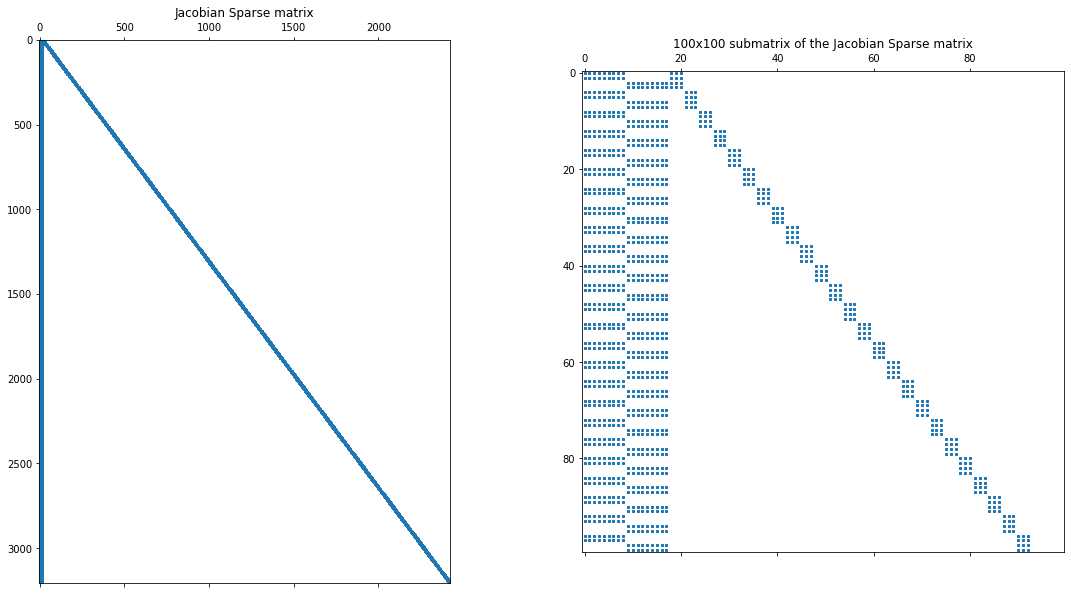

In [ ]:
## Plot of the Jacobian Sparse matrix
J = badj.bundle_adjustment_sparsity(len(cams_ba), len(X_ba), cam_idxs, x_idxs)

plt.subplot(1,2,1)
plt.spy(J, markersize=2)
plt.title('Jacobian Sparse matrix')

plt.subplot(1,2,2)
plt.spy(J[:100,:100], markersize=2)
plt.title('100x100 submatrix of the Jacobian Sparse matrix')

In [ ]:
## Quantitative results

# Value of the re-projection error before Bandle Adjustment
x0 = np.hstack((cams_ba.ravel(), X_ba.ravel()))
res = badj.fun(x0, cams_ba.shape[0], X_ba.shape[0], cam_idxs, x_idxs, x_ba)
reproj_error = np.sum(res**2)
print('Re-projection error before Bandle Adjustment: %.2e' % reproj_error)

# Value of the re-projection error after Bandle Adjustment
x_final = np.hstack((camsba.ravel(), Xba.ravel()))
res_ba = badj.fun(x_final, camsba.shape[0], Xba.shape[0], cam_idxs, x_idxs, x_ba)
reproj_error_ba = np.sum(res_ba**2)
print('Re-projection error after Bandle Adjustment: %.2e' % reproj_error_ba)

Re-projection error before Bandle Adjustment: 1.72e+09
Re-projection error after Bandle Adjustment: 8.03e+03


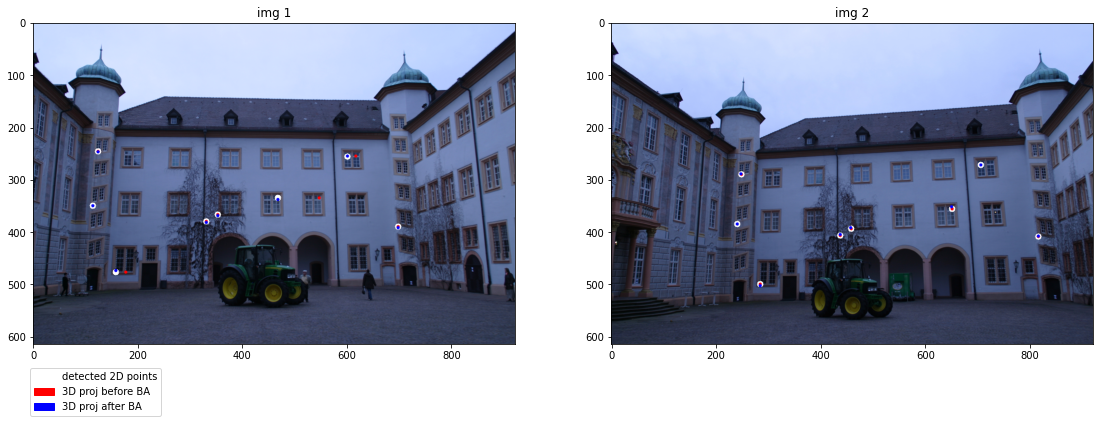

In [ ]:
## Qualitative results

# 2D points for image 1 and 2
x1 = x_ba[cam_idxs == 0]
x2 = x_ba[cam_idxs == 1]

# Projection of the 3D points to each image before Bundle Adjustment
P1 = cams_euc[0]
P2 = cams_euc[1]
X_ba_h = np.vstack((X_ba.T, np.ones(len(X_ba))))
x1_proj_e = projective2img(P1 @ X_ba_h).T
x2_proj_e = projective2img(P2 @ X_ba_h).T

# Projection of the 3D points to each image after Bundle Adjustment
x_ba_proj = badj.project(Xba[x_idxs], camsba[cam_idxs])
x1_proj_ba_e = x_ba_proj[cam_idxs == 0]
x2_proj_ba_e = x_ba_proj[cam_idxs == 1]

# Plot of these points over the images
import matplotlib.patches as mpatches

img1_rgb = rgb_imgs[0].copy()
img2_rgb = rgb_imgs[1].copy()

idxs = set(np.random.randint(0, len(x1_proj_e), 5)).union({551, 209, 513})

for i, indice in enumerate(idxs):
    cv2.circle(img1_rgb, (int(x1[indice][0]), int(x1[indice][1])), 6, (255,255,255), -1)
    cv2.circle(img1_rgb, (int(x1_proj_e[indice][0]), int(x1_proj_e[indice][1])), 3, (255,0,0), -1)
    cv2.circle(img1_rgb, (int(x1_proj_ba_e[indice][0]), int(x1_proj_ba_e[indice][1])), 3, (0,0,255), -1)

for i, indice in enumerate(idxs):
    cv2.circle(img2_rgb, (int(x2[indice][0]), int(x2[indice][1])), 6, (255,255,255), -1)
    cv2.circle(img2_rgb, (int(x2_proj_e[indice][0]), int(x2_proj_e[indice][1])), 3, (255,0,0), -1)
    cv2.circle(img2_rgb, (int(x2_proj_ba_e[indice][0]), int(x2_proj_ba_e[indice][1])), 3, (0,0,255), -1)

plt.subplot(1,2,1)
plt.imshow(img1_rgb)
plt.title('img 1')

plt.subplot(1,2,2)
plt.imshow(img2_rgb)
plt.title('img 2')

values = [0,1,2]
colors = [(1,1,1), (1,0,0), (0,0,1)]
labels = ['detected 2D points', '3D proj before BA', '3D proj after BA']
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(-1.07, -0.15), loc=10, borderaxespad=0. )

# Optional tasks
- Estimate affine homography from the 3 vanishing points and F (Alg. 13.1 p332, result 10.3 p271)
- Perform Bundle Adjustment over the estimation of the vanishing points and all available images, with PySBA

For more than 2 images: 
- Investigate strategies to improve the pipeline:
   -in results: number of points, reprojection error, camera poses
   -in implementation: time of computation, resources, etc.
   Reference papers for improvement strategies: 
       -J. L. Schönberger and J. Frahm, "Structure-from-Motion Revisited," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, 2016, pp. 4104-4113.
- Implement the  resection method, as explained in MVG, Alg 7.1
- Implement track management for more than 2 images, with tracks structure

In [ ]:
def resection(tracks, cam_id):
    # extract 3D-2D correspondences from tracks
    Xi = np.asarray([t.pt for t in tracks if cam_id in t.views and t.pt[3] != 0])
    xi = np.asarray([t.views[cam_id] for t in tracks if cam_id in t.views and t.pt[3] != 0])
    
    # ________________________
    # Your code here
    # ________________________
    
    return P

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ae227f6-5f90-4988-964f-55990e13b4eb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>